In [125]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [126]:
image_to_tensor = torchvision.transforms.ToTensor()
tensor_to_image = torchvision.transforms.ToPILImage()

mnist_train = torchvision.datasets.MNIST('../data/', train= True, transform=image_to_tensor, download=True)
mnist_test = torchvision.datasets.MNIST('../data/', train= False, transform=image_to_tensor, download=True)

In [128]:
assert len(mnist_train) == 60000
assert len(mnist_test) == 10000
figure, label = mnist_train[0]
D = figure.numel()
L = figure.shape[-1]
assert D == 784
assert L**2 == D

In [129]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=128, shuffle=True)

In [625]:
class FeedForward(nn.Module):
    def __init__(self, D, nlayers =8):
        super(FeedForward, self).__init__()
        assert type(D) == int
        assert type(nlayers) == int
        self.D = D
        self.nlayers = nlayers
        self.first = nn.Linear(D+1, D)
        self.linears = nn.ModuleList([nn.Linear(D, D) for i in range(nlayers-1)])     

    def forward(self, x, t):
        x = torch.cat((x, t.reshape(-1, 1)), axis=1)
        x = self.first(x)
        for lin in self.linears:
            x = lin(F.relu(x))
        return x
    


class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        assert dim%2 ==0, 'dim has to be even'
        self.dim = dim

        self.inv_freq = torch.exp(torch.arange(0, self.dim, 2, dtype=torch.float32)*(-math.log(10000)/self.dim)).to(dvc)

        self.mlp = nn.Sequential(
            nn.Linear(self.dim, self.dim),
            nn.ReLU(),
            nn.Linear(self.dim, self.dim)
        )

    def forward(self, time):
        sinusoid_in = torch.ger(time.view(-1).float(), self.inv_freq)
        time = torch.cat([sinusoid_in.sin(), sinusoid_in.cos()], dim=-1)
        return self.mlp(time)
    

class LabelEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(
            nn.Linear(10, self.dim),
            nn.ReLU(),
            nn.Linear(self.dim, self.dim)
        )
        
    def forward(self, labels):
        labels = F.one_hot(labels, 10).to(torch.float32)
        return self.mlp(labels)
    

class Embedding(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        self.time_emb = TimeEmbedding(dim)
        self.label_emb = LabelEmbedding(dim)

    def forward(self, l, t):
        return self.label_emb(l) + self.time_emb(t)



class ConvNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.in_conv = nn.Conv2d(in_channels, in_channels, 7, padding=3, groups=in_channels)

        self.block = nn.Sequential(
            nn.GroupNorm(1, self.in_channels),
            nn.Conv2d(self.in_channels, self.out_channels, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, self.out_channels),
            nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(self.in_channels, self.out_channels, 1) if in_channels != out_channels  else nn.Identity()
        self.emb = Embedding(self.out_channels)

    def forward(self, x, l, t):

        emb = self.emb(l, t)
        x_in = self.in_conv(x)

        x_block = self.block(x_in) + emb[:,:,None,None]
        x_res = self.res_conv(x)

        return x_block + x_res
    


class DownBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.conv_list = nn.ModuleList([
            ConvNetBlock(self.in_channels, self.out_channels),
            ConvNetBlock(self.out_channels, self.out_channels)
        ])
        
        self.down = nn.MaxPool2d(2, 2)
        
    def forward(self, x, l, t):
        for block in self.conv_list:
            x = block(x, l, t)
        return self.down(x), x
    

class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.up = nn.Upsample(scale_factor=2)

        self.conv_list = nn.ModuleList([
            ConvNetBlock(self.in_channels*2, self.out_channels),
            ConvNetBlock(self.out_channels, self.out_channels)
        ])

    def forward(self, x, l, t, a):
        x = self.up(x)
        x = torch.cat((a, x), axis=1)
        for block in self.conv_list:
            x = block(x, l, t)
        return x

        

class GatedAttention(nn.Module):

    def __init__(self, channels):
        super().__init__()
        self.channels = channels

        self.conv = nn.Conv2d(self.channels, self.channels, 2, 2)

        self.gate = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(self.channels, 1, 3, padding=1),
            nn.Sigmoid(),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x, g):
        return self.gate(self.conv(x) + g)*x
    

class MultiHeadAttention(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mha = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)

    def forward(self, x):

        B, S = x.shape[0], x.shape[-1]
        x = torch.swapaxes(x.reshape(B, self.dim, -1), 1, 2)
        x, _ = self.mha(x,x,x)
        return torch.swapaxes(x, 1,2).reshape((B, self.dim, -1, S))
    
        

class UNet(nn.Module):
    
    def __init__(self, dim):
        super().__init__()

        self.dim = dim

        self.input = nn.Sequential(
            nn.InstanceNorm2d(1),
            nn.Conv2d(1, self.dim, 3, padding=1),
            nn.ReLU()
        )

        self.down = nn.ModuleList([
            DownBlock(self.dim, self.dim*2),
            DownBlock(self.dim*2, self.dim*4)
        ])

        self.bottom = ConvNetBlock(dim*4, dim*4)

        self.att = nn.ModuleList([
            GatedAttention(dim*4),
            GatedAttention(dim*2)
        ])

        self.up = nn.ModuleList([
            UpBlock(self.dim*4, self.dim*2),
            UpBlock(self.dim*2, self.dim)
        ])

        self.top = ConvNetBlock(self.dim, self.dim)
        
        self.output = nn.Conv2d(self.dim, 1, 3, padding=1)
    
    def forward(self, x, l, t):

        residuals = []

        x = self.input(x)

        for down_block in self.down:
            x, res = down_block(x, l, t)
            residuals.append(res)

        x = self.bottom(x, l, t)

        for attention, block in zip(self.att, self.up):
            res = residuals.pop()
            a = attention(res, x)
            x = block(x, l, t, a)

        x = self.top(x, l, t)

        x = self.output(x)
        
        return x


class Diffusion():
    def __init__(self, T, S, betas, UNet_dim = 16):
        assert type(T) == int
        self.T = T
        self.S = S
        self.betas = torch.tensor(betas).repeat(T) if type(betas) == float else betas
        self.alphas = 1-self.betas.to(dvc)
        self.alphas_hat = torch.cumprod(self.alphas, axis=0).to(dvc)
        self.sigma = 0.02
        self.normal = torch.distributions.Normal(torch.tensor([0.]), torch.tensor([1.]))
        self.UNet_dim = UNet_dim
        self.UNet = UNet(self.UNet_dim).to(dvc)

    
    def sample_eps(self, size):
        return self.normal.sample(size).to(dvc)
        

    def sample_t(self, B, all_equal = True):
        if all_equal:
            t = torch.randint(0, self.T, torch.Size([1]), device=dvc).repeat(B)
        else:
            t = torch.randint(0, self.T, torch.Size([B]), device = dvc)
        return t
    
    def load_UNet(self, path):
        self.UNet.load_state_dict(torch.load(path))


    def generate(self, num, save_steps = []):

        assert type(num) == int, "'num' has to be an integer"
        num, B, S = torch.tensor([num], device=dvc), 1, self.S


        process = []
        self.UNet.eval()




        xT = self.sample_eps(torch.Size([B*self.L**2])).reshape((B,1,self.L,self.L))
        if len(save_steps) > 0:
            process.append(torch.squeeze(xT.detach().to('cpu')))

        xt = xT

        for t in reversed(range(self.T)):

            z = self.sample_eps(torch.Size([B*S**2])).reshape((B,1,S,S)) if t>=1 else 0
            alpha, alpha_hat, sigma = self.alphas[t], self.alphas_hat[t], self.sigma

            eps_pred = self.UNet(xt, num, torch.tensor([t], device=dvc).repeat(B))

            xt = (xt - eps_pred*(1-alpha)/torch.sqrt(1-alpha_hat))/torch.sqrt(alpha) + 0.02*z

            if t in save_steps:
                process.append(torch.squeeze(xt.detach().to('cpu')))

        x0 = torch.squeeze(xt.detach().to('cpu'))
        if len(save_steps) > 0:
            process.append(x0)

        return x0, process
    


    def train(self, epochs, optimizer, scheduler, verbose=True):
        
        S = self.S
        alphas_hat_array = self.alphas_hat.repeat_interleave(S**2).view(-1,1,S,S)

        L2_loss = torch.nn.MSELoss(reduction='sum')

        for epoch in range(epochs):
            epoch_loss = 0

            for x0, l in tqdm(trainloader):

                optimizer.zero_grad()

                B = x0.shape[0]
                x0, l = x0.to(dvc), l.to(dvc)

                t = self.sample_t(B, all_equal=False)
                eps = self.sample_eps(torch.Size([x0.numel()])).reshape_as(x0)
                
                alphas_hat = alphas_hat_array[t]
                x = x0*torch.sqrt(alphas_hat) + eps*torch.sqrt(1-alphas_hat)

                eps_pred  = self.UNet(x, l, t)
                loss = L2_loss(eps, eps_pred)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
            
            scheduler.step()

            if verbose:
                print(f'epoch: {epoch+1} \t loss: {epoch_loss}')
        
        


def plot_num(x, cmap='grey'):
    
    assert x.ndim == 2
    fig = plt.imshow(x, cmap=cmap)
    plt.axis('off')

    return fig

def plot_process(x, space=False, cmap='grey'): 
    fig, axes = plt.subplots(1, len(x), figsize=(2*len(x), len(x)))

    for i, ax in enumerate(axes):
        ax.imshow(x[i], cmap=cmap)
        ax.axis('off')
        if space:
            plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


In [612]:
epochs = 100
loss_hist = []

diff = Diffusion(T = 100, L = 28, betas = torch.linspace(1e-04, 2e-02, 100), UNet_dim=16)

optimizer = torch.optim.Adam(diff.UNet.parameters(), lr = 1e-03)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [
    torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50, 1e-04),
    torch.optim.lr_scheduler.LinearLR(optimizer, .1, .01, 50)], [50])
L2_loss = torch.nn.MSELoss(reduction='sum')


os.path.join(os.path.pardir, 'models', model_name)

'../models/UNet_dim16_2024-07-04-12-28.pth'

In [613]:
model_name = 'UNet_dim16_2024-07-04-12-28.pth'
path = os.path.join(os.path.pardir, 'models', model_name)

diff.load_UNet(path)


In [614]:
x0, process = diff.generate(9, [i*10 for i in range(1, 10)])

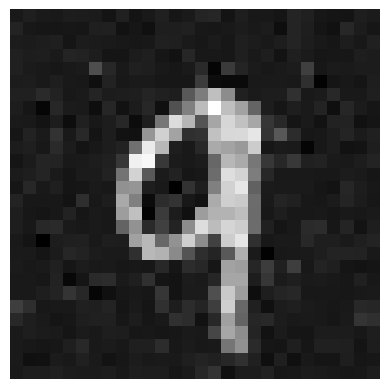

In [615]:
plot_num(x0)


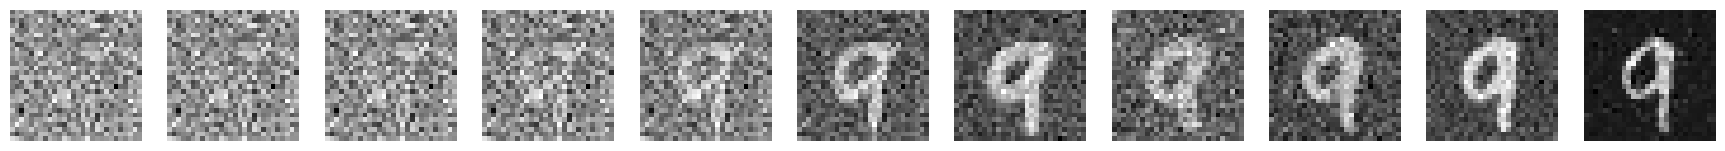

In [616]:
plot_process(process)

In [621]:
alphas_hat_array = diff.alphas_hat.repeat_interleave(L*L).view(-1,1,L,L)

for epoch in range(epochs):
    epoch_loss = 0

    for x0, l in tqdm(trainloader):

        optimizer.zero_grad()

        B = x0.shape[0]

        x0, l = x0.to(dvc), l.to(dvc)

        t = diff.sample_t(B, all_equal=False)
        eps = diff.sample_eps(torch.Size([x0.numel()])).reshape_as(x0)
        
        alphas_hat = alphas_hat_array[t]
        x = x0*torch.sqrt(alphas_hat) + eps*torch.sqrt(1-alphas_hat)

        eps_pred  = eps_theta(x, l, t)
        loss = L2_loss(eps, eps_pred)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    scheduler.step()

    print(f'epoch: {epoch+1} \t loss: {epoch_loss}')
    loss_hist.append(epoch_loss)

  5%|▍         | 23/469 [00:03<01:13,  6.03it/s]


KeyboardInterrupt: 

In [ ]:
diff.unet.load_state_dict(torch.load(os.path.join(os.path.pardir, 'models', model_name)))

<All keys matched successfully>

In [629]:
diff = Diffusion(T = 100, S = 28, betas = torch.linspace(1e-04, 2e-02, 100), UNet_dim=32)

optimizer = torch.optim.Adam(diff.UNet.parameters(), lr = 1e-03)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [
    torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50, 1e-04),
    torch.optim.lr_scheduler.LinearLR(optimizer, .1, .01, 50)], [50])

diff.train(100, optimizer, scheduler)

100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 1 	 loss: 9297914.193847656


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 2 	 loss: 3451823.6752929688


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 3 	 loss: 3006718.7348632812


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 4 	 loss: 2789019.55078125


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 5 	 loss: 2631359.4912109375


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 6 	 loss: 2498299.844970703


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 7 	 loss: 2397185.5173339844


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 8 	 loss: 2328280.792236328


100%|██████████| 469/469 [02:32<00:00,  3.09it/s]


epoch: 9 	 loss: 2277337.541015625


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 10 	 loss: 2221064.8979492188


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 11 	 loss: 2199569.529296875


100%|██████████| 469/469 [02:32<00:00,  3.09it/s]


epoch: 12 	 loss: 2141375.749267578


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 13 	 loss: 2134687.126953125


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 14 	 loss: 2084353.3051757812


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 15 	 loss: 2077078.5905761719


100%|██████████| 469/469 [02:32<00:00,  3.09it/s]


epoch: 16 	 loss: 2048680.1997070312


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 17 	 loss: 2035878.5380859375


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 18 	 loss: 2029701.4389648438


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 19 	 loss: 2003455.3095703125


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 20 	 loss: 1990376.4899902344


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 21 	 loss: 1988060.8571777344


100%|██████████| 469/469 [02:32<00:00,  3.09it/s]


epoch: 22 	 loss: 1973586.837890625


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 23 	 loss: 1968187.9348144531


100%|██████████| 469/469 [02:32<00:00,  3.09it/s]


epoch: 24 	 loss: 1944463.9353027344


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 25 	 loss: 1932192.9416503906


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 26 	 loss: 1937811.8041992188


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 27 	 loss: 1919779.7504882812


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 28 	 loss: 1912310.6669921875


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 29 	 loss: 1906730.4099121094


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 30 	 loss: 1902866.4765625


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 31 	 loss: 1886457.845703125


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 32 	 loss: 1883780.7856445312


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 33 	 loss: 1877709.5654296875


100%|██████████| 469/469 [02:32<00:00,  3.09it/s]


epoch: 34 	 loss: 1864868.1557617188


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 35 	 loss: 1848577.9665527344


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 36 	 loss: 1861248.6953125


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


epoch: 37 	 loss: 1853351.3820800781


100%|██████████| 469/469 [2:10:09<00:00, 16.65s/it]   


epoch: 38 	 loss: 1851786.1042480469


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


epoch: 39 	 loss: 1845442.4311523438


100%|██████████| 469/469 [02:33<00:00,  3.05it/s]


epoch: 40 	 loss: 1845902.8415527344


100%|██████████| 469/469 [02:37<00:00,  2.99it/s]


epoch: 41 	 loss: 1835960.5024414062


100%|██████████| 469/469 [02:41<00:00,  2.91it/s]


epoch: 42 	 loss: 1817560.5502929688


100%|██████████| 469/469 [02:43<00:00,  2.86it/s]


epoch: 43 	 loss: 1818650.2036132812


100%|██████████| 469/469 [02:44<00:00,  2.85it/s]


epoch: 44 	 loss: 1819112.9038085938


100%|██████████| 469/469 [02:44<00:00,  2.86it/s]


epoch: 45 	 loss: 1815829.8615722656


100%|██████████| 469/469 [02:46<00:00,  2.82it/s]


epoch: 46 	 loss: 1816479.7897949219


100%|██████████| 469/469 [02:42<00:00,  2.89it/s]


epoch: 47 	 loss: 1820866.8547363281


100%|██████████| 469/469 [02:47<00:00,  2.80it/s]


epoch: 48 	 loss: 1810149.2658691406


100%|██████████| 469/469 [02:46<00:00,  2.81it/s]


epoch: 49 	 loss: 1820407.0625


100%|██████████| 469/469 [02:47<00:00,  2.80it/s]
/Users/stefano.damato/anaconda3/envs/dabf/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 50 	 loss: 1808181.1015625


100%|██████████| 469/469 [02:41<00:00,  2.90it/s]


epoch: 51 	 loss: 1791816.2197265625


100%|██████████| 469/469 [02:41<00:00,  2.91it/s]


epoch: 52 	 loss: 1803355.2084960938


100%|██████████| 469/469 [02:48<00:00,  2.78it/s]


epoch: 53 	 loss: 1817135.638671875


100%|██████████| 469/469 [02:43<00:00,  2.87it/s]


epoch: 54 	 loss: 1802467.4584960938


100%|██████████| 469/469 [02:40<00:00,  2.92it/s]


epoch: 55 	 loss: 1805744.6779785156


100%|██████████| 469/469 [08:16<00:00,  1.06s/it]


epoch: 56 	 loss: 1805758.8483886719


 54%|█████▍    | 254/469 [15:22<13:46,  3.84s/it]

In [ ]:

from datetime import datetime

dt = datetime.now().strftime("%Y-%m-%d-%H-%M")
dt

model_name = '_'.join(['UNet', 'dim'+str(eps_theta.dim), dt]) + '.pth'
model_name

'UNet_dim16_2024-07-04-12-28.pth'

In [ ]:
import os

os.path.pardir, os.path.join(os.path.pardir, 'models', model_name)


('..', '../models/UNet_dim16_2024-07-04-12-28.pth')

In [ ]:
torch.save(diff.UNet.state_dict(), os.path.join(os.path.pardir, 'models', model_name))

In [ ]:

eps_theta

eps_theta.eval()
B = 10

xT = diff.sample_eps(torch.Size([B*L**2])).reshape((B,1,L,L))

xt = xT


for t in reversed(range(diff.T)):
    z = diff.sample_eps(torch.Size([B*L**2])).reshape((B,1,L,L)) if t>1 else 0

    alpha, alpha_hat, sigma = diff.alphas[t], diff.alphas_hat[t], diff.sigmas[t]

    #print(torch.arange(10, device=dvc).device, torch.tensor([t], device=dvc).repeat(B).device)

    eps_pred = eps_theta(xt, torch.arange(10, device=dvc), torch.tensor([t], device=dvc).repeat(B))

    xt = (xt - eps_pred*(1-alpha)/torch.sqrt(1-alpha_hat))/torch.sqrt(alpha) + 0.02*z 

x0 = xt

torch.cat(([x[i,0,:,:] for i in range(10)]), axis=1)

tensor([[-0.2205, -0.2074, -0.2281,  ..., -0.4939, -0.6606, -0.2222],
        [-0.5510,  0.4435,  0.8957,  ..., -0.1441,  0.0014,  0.1535],
        [-0.0236,  0.4118, -0.5435,  ...,  0.2025, -0.4637, -0.2617],
        ...,
        [-0.6462, -0.1609, -0.9810,  ..., -0.8971,  0.6637,  0.0587],
        [-0.7763,  0.4799,  0.4919,  ..., -0.4495,  0.4826, -0.5854],
        [ 0.7965, -0.0060,  0.7209,  ..., -0.1298,  0.3027,  0.4686]],
       device='mps:0')

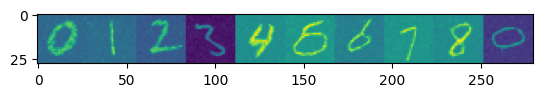

In [ ]:
eps_theta

eps_theta.eval()

n = 5

xT = diff.sample_eps(torch.Size([1*L**2])).reshape((1,1,L,L))

denoising = []


for t in reversed(range(diff.T)):

    z = diff.sample_eps(torch.Size([B*L**2])).reshape((B,1,L,L)) if t>1 else 0

    alpha, alpha_hat, sigma = diff.alphas[t], diff.alphas_hat[t], diff.sigmas[t]

    #print(torch.arange(10, device=dvc).device, torch.tensor([t], device=dvc).repeat(B).device)

    eps_pred = eps_theta(xt, torch.tensor(([n]), device=dvc), torch.tensor([t], device=dvc))

    xt = (xt - eps_pred*(1-alpha)/torch.sqrt(1-alpha_hat))/torch.sqrt(alpha) + (0.05*z if t > 0 else 0.)

    if t%10 == 0:
        denoising.append(xt.detach())

x0 = xt

In [ ]:
def scale01(x):
    m, M = torch.min(x, axis=1)[0], torch.max(x, axis=1)[0]
    return (x-m)/(M-m)


def plotseq(imgs : list, scale = False):
    if type(scale) == bool:
        if scale:
            imgs = [scale01(x) for x in imgs]
    elif type(scale) == list:
        for i in range(len(imgs)):
            x[i] = scale01(x[i]) if scale[i] == True else x[i]
    else:
        raise ValueError

    return plt.imshow(torch.cat(imgs, axis=1), cmap='grey')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

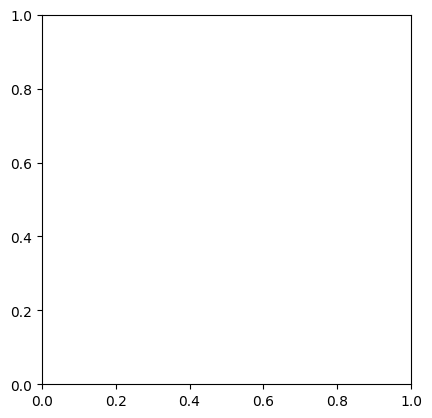

In [ ]:
plt.imshow(torch.cat([x0[i,0,:,:] for i in range(10)], axis=1))

In [ ]:
i = 8
plt.imshow(torch.cat((scale01(xT[i,0]),x0[i,0]), axis=1).detach().numpy())

[0.001]
[0.0009997779521645793]
[0.0009991120277927223]
[0.000998002884071386]
[0.000996451615591515]
[0.000994459753267812]
[0.0009920292628279098]
[0.000989162542872436]
[0.0009858624225078836]
[0.000982132158554624]
[0.0009779754323328187]
[0.0009733963460294011]
[0.0009683994186497127]
[0.000962989581557791]
[0.0009571721736097084]
[0.0009509529358847651]
[0.0009443380060197382]
[0.0009373339121517743]
[0.0009299475664759064]
[0.0009221862584235525]
[0.000914057647468726]
[0.0009055697555690603]
[0.0008967309592491047]
[0.0008875499813337064]
[0.0008780358823396348]
[0.000868198051533946]
[0.0008580461976679096]
[0.000847590339395643]
[0.0008368407953869101]
[0.0008258081741438392]
[0.0008145033635316127]
[0.0008029375200334586]
[0.0007911220577405481]
[0.0007790686370876667]
[0.0007667891533457716]
[0.0007542957248827957]
[0.0007416006812042824]
[0.0007287165507856509]
[0.0007156560487081049]
[0.0007024320641103809]
[0.0006890576474687261]
[0.0006755459977176529]
[0.00066191044922

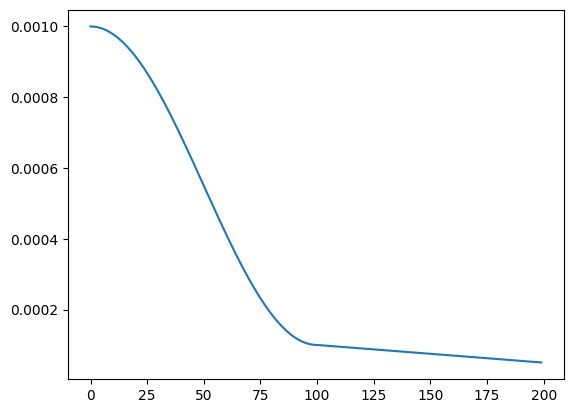

In [ ]:
optimizer = torch.optim.Adam(eps_theta.parameters(), lr = 1e-03)

#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1e-02, 1e-03, 10 )
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, .9)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [
    torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, 1e-04),
    torch.optim.lr_scheduler.LinearLR(optimizer, .1, .05, 100)], [100])
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, 1e-03)
rates =[]

for epoch in range(200):
    rates.append(scheduler.get_last_lr())
    optimizer.step()
    print(rates[-1])
    scheduler.step()

plt.plot(rates)


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(32, in_channel)
        self.qkv = conv2d(in_channel, in_channel * 3, 1)
        self.out = conv2d(in_channel, in_channel, 1, scale=1e-10)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input

True

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mha = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)

    def forward(self, x):

        B, S = x.shape[0], x.shape[-1]
        x = torch.swapaxes(x.reshape(B, self.dim, -1), 1, 2)
        x, _ = self.mha(x,x,x)
        return torch.swapaxes(x, 1,2).reshape((B, self.dim, -1, S))


mha = MultiHeadAttention(128)

mha(x).shape


torch.Size([17, 128, 7, 7])

In [ ]:
mha = torch.nn.MultiheadAttention(embed_dim= 49, num_heads=1, batch_first=True)

def num_params(model):
    return sum([p.numel() for p in model.parameters()])

x = torch.randn((B))

9800

In [ ]:
dim = 16

x = torch.randn((17, dim*4, 7, 7))

class MultiHeadAttention(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mha = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)

    def forward(self, x):

        B, S = x.shape[0], x.shape[-1]
        x = torch.swapaxes(x.reshape(B, self.dim, -1), 1, 2)
        print(x.shape)
        x, _ = self.mha(x,x,x)
        return torch.swapaxes(x, 1,2).reshape((B, self.dim, -1, S))
    



te = torch.randn((17,64))

te + mha(x)

torch.Size([17, 49, 64])


RuntimeError: The size of tensor a (64) must match the size of tensor b (7) at non-singleton dimension 3

In [ ]:
labels = torch.tensor([2, 5])

F.one_hot(labels, 10)

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])